In [298]:
#############################################
#BASIC PACKAGES
import sys,time,os
from copy import deepcopy as dcopy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

#############################################
#PATH TO SCRIPTS FOLDER
path = '/data/AMARINS/CMBWLxHI-CODES/scripts/'
sys.path.insert(1, path)
import cross_functions_theory      as cxft
import healpy        as hp
import handling_data as hdata
import noise_functions as fnoise
import pandas as pd

#############################################
## MATPLOTLIB FEATURES
from matplotlib import cm
font = {'weight' : 'bold','size'   : 22}
mpl.rc('font', **font)
mpl.rc('font',   size=209)  #set defaults so that the plots are readable
mpl.rc('axes',   titlesize=20)
mpl.rc('axes',   labelsize=20)
mpl.rc('xtick',  labelsize=20)
mpl.rc('ytick',  labelsize=20)
mpl.rc('legend', fontsize =20)
mpl.rc('figure', titlesize=20)
mpl.rc('text',   usetex=True)

## FURTHER MATPLOTLIB FEATURES
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
colors = ['black','darkgrey', '#0000ff', '#ff0000', '#0000FF',  '#FF0000', '#069AF3', '#00008B','#C79FEF','#DC143C','#C875C4','#9A0EEA','darkorange','#C79FEF','#7E1E9C','silver','#FF7F50','#FC5A50',
          '#FFA500','#F97306','#FFD700','#DDA0DD','#00008B','#069AF3','#0000FF','#00FFFF','#13EAC9','#7FFFD4','#04D8B2','#40E0D0']
my_cmap = ListedColormap(colors, name="my_cmap")
font_dict = {'family': 'serif', 'color':  None,  'weight': 'bold','size': 30}

#############################################
## NAMASTER (https://namaster.readthedocs.io/en/latest/)
import pymaster as nmt
del_l  = 20
nside  = 256
##############################
b    = nmt.NmtBin.from_nside_linear(nside, nlb=del_l)
leff = b.get_effective_ells()
feff = leff*(leff+1)/2/np.pi

### LOWZ

In [299]:
def cl_dict_function(L0_dir='sim0', ins_='ns4',verbose=False, type_field='cmb', hi_regime='lowz'):
    timej=time.time()
    if (hi_regime=='lowz')*(type_field=='cmb'):
        prefix = 'lowz_nch30_980_1260'
    elif (hi_regime=='lowz')*(type_field=='gal'):
        prefix = 'lowz_nch30_980_1260_nch25_30'        
    elif (hi_regime=='highz')*(type_field=='cmb'):
        prefix = 'highz_nch70_350_1050'        
    elif (hi_regime=='highz')*(type_field=='gal'):
        prefix = 'highz_nch70_350_1050_nch65_70'                
    else:
        raise NameError('CHANGE THE VARIABLES')
        
    dirpath_out = '/data/AMARINS/CMBWLxHI-DATA/postprocessed/fullsky/{}'.format(prefix)
    dirpath_out_ns = os.path.join(dirpath_out, ins_)
    dirpath_sims   = os.path.join(dirpath_out_ns,'simulations')
    dirpath_rec    = os.path.join(dirpath_out_ns,'estimated')
    dirpath_cross  = os.path.join(dirpath_out_ns,'cross')    
        
    cl_f1_sim = np.loadtxt(os.path.join(dirpath_sims,L0_dir, 'cl_field1_sim.txt')).T[1:,:]
    cl_f2_sim = np.loadtxt(os.path.join(dirpath_sims,L0_dir, 'cl_field2_sim.txt')).T[1:,:]    
    cl_f1_rec = np.loadtxt(os.path.join(dirpath_rec ,L0_dir ,'cl_field1_rec.txt')).T[1:,:]
    W_fg_rec  = np.loadtxt(os.path.join(dirpath_rec ,L0_dir ,'filter_fg.txt')).T#[1:,:]
    
    cl_cx_field1_field2_sim_sim = np.loadtxt(os.path.join(dirpath_sims , L0_dir, 'cl_cx_field1_field2_sim_sim.txt')).T[1:,:]    
    cl_cx_field1_field2_rec_sim = np.loadtxt(os.path.join(dirpath_cross, L0_dir, 'cl_cx_field1_field2_rec_sim.txt')).T[1:,:]
  
    if verbose: print('Processing time: {0:.4f} seg'.format(time.time()-timej)) 
    return  {'cl_f1_sim':cl_f1_sim, 'cl_f2_sim':cl_f2_sim,
             'cl_cx_f1_f2_sim_sim':cl_cx_field1_field2_sim_sim,
             'cl_f1_rec':cl_f1_rec, 'W_fg_rec':W_fg_rec,
             'cl_cx_f1_f2_rec_sim':cl_cx_field1_field2_rec_sim,
            }

def SN_per_ell_per_nu(CLs_dict_=None, ins_=None, clcx_=None,leakage=False, leakage_type='gal',
                      ibin=None, cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_rec', f2_label='cl_f2_sim', hi_regime='lowz',
                      noise_f1=0, noise_f2=0, beam_f1=0, beam_f2=0, fsky=1, delell=1, elleff=None, verbose=False):
    timej=time.time()    
    if leakage:
        lkg = leakage_theorectical(ins_=ins_, hi_regime=hi_regime)
        #lkg = leakage_theorectical(CLs_dict_=CLs_dict_, ins_=ins_, clcx_=clcx_, bins_=bins_, calculate=calculate)
        lkg = lkg[leakage_type][ibin]
    else:
        lkg=0
    try:
        noise_f1=noise_f1[ibin]
    except:
        noise_f1=0
    try:
        noise_f2=noise_f2[ibin]
    except:
        noise_f2=0       
    cx_rec_part = b.bin_cell(CLs_dict_[ins_][cx_label][ibin] + lkg)
    c1_rec_part = b.bin_cell(CLs_dict_[ins_][f1_label][ibin] + noise_f1/(beam_f1**2))
    c2_sim_part = b.bin_cell(CLs_dict_[ins_][f2_label][0]    + noise_f2/(beam_f2**2))
    err_rec     = np.sqrt( cx_rec_part**2   + c1_rec_part*c2_sim_part  )
    err_rec     = err_rec/np.sqrt( (2*elleff+1)*fsky*delell )
    if verbose: print('Processing time: {0:.4f} seg'.format(time.time()-timej))     
    return cx_rec_part/err_rec


def cumulative_SN(CLs_dict_=None, clcx_=None, bins_=None, ins_=None, sim_names_=None, 
                  leakage=False, leakage_type='gal', hi_regime='lowz', type_field='gal',
                  cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_rec', f2_label='cl_f2_sim',
                  noise_f1=0,noise_f2=0, beam_f1=0,beam_f2=0, fsky=1, delell=1,elleff=None,verbose=False):
    timej=time.time()    
    for j,jsim in enumerate(sim_names_):
        cls_dict = {ins:cl_dict_function(L0_dir=jsim, ins_=ins_,type_field=type_field, hi_regime=hi_regime, verbose=False)}
        for jj,ibin in enumerate(bins_):
            sn = SN_per_ell_per_nu(CLs_dict_=CLs_dict_, clcx_=clcx_, ibin=ibin, ins_=ins_,
                                          leakage  = leakage , calculate = calculate, leakage_type=leakage_type,
                                          cx_label = cx_label, f1_label  = f1_label , f2_label=f2_label, hi_regime=hi_regime,
                                          noise_f1 = noise_f1, noise_f2  = noise_f2 , 
                                          beam_f1  = beam_f1 , beam_f2   = beam_f2  , 
                                          fsky=fsky, delell=delell, elleff=elleff, 
                                          verbose=verbose)
            #sn = np.sqrt(sn**2)
            sn_m = np.sum(sn) if not jj else np.hstack(( sn_m, np.sum(sn) ))
        SN = sn_m if not j else np.hstack(( SN, np.sum(sn_m) ))
    SN = np.average( SN , axis=0 ).reshape(-1,len(bins_)) 
        
    if verbose: print('Processing time: {0:.4f} seg'.format(time.time()-timej))     
    return SN

def SN_per_ell_per_nu_mean(ins_=None, clcx_=None, bins_=None,
                           leakage=False, leakage_type='gal', hi_regime='lowz', type_field = 'gal', sim_names_=None,
                           cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_rec', f2_label='cl_f2_sim', 
                           noise_f1=0, noise_f2=0, beam_f1=0, beam_f2=0, fsky=1, delell=1, elleff=None, verbose=False):
    for j,jbin in enumerate(bins_):    
        for jj,jsim in enumerate(sim_names_):
            cls_dict_ = {ins_:cl_dict_function(L0_dir=jsim, ins_=ins_,
                                              type_field=type_field, 
                                              hi_regime=hi_regime, 
                                              verbose=verbose)}
            sn_ = SN_per_ell_per_nu(CLs_dict_=cls_dict_, ins_=ins_, 
                                    clcx_=clcx_, hi_regime=hi_regime,
                                    leakage_type=lkg_field, leakage=leakage, ibin=jbin, 
                                    cx_label= cx_label, f1_label=f1_label, f2_label=f2_label,
                                    noise_f1=noise_f1, beam_f1=beam_f1, 
                                    noise_f2=noise_f2, beam_f2=beam_f2, 
                                    delell=delell, elleff=elleff, fsky=fsky,
                                    verbose=verbose)
            sn_vec = sn_ if not jj else np.vstack(( sn_vec, sn_ ))
            del sn_, cls_dict_
        sn_vec = np.average( sn_vec , axis=0 )
        SN_ = sn_vec if not j else np.vstack(( SN_, sn_vec ))
        del sn_vec
    return SN_


def SN_per_nu_mean(ins_=None, clcx_=None, bins_=None, NS=['ns3','ns4','ns5'],
                   leakage=False, leakage_type='gal', hi_regime='lowz', type_field = 'gal', sim_names_=None,
                   cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_rec', f2_label='cl_f2_sim', 
                   noise_f1=0, noise_f2=0, beam_f1=0, beam_f2=0, fsky=1, delell=1, elleff=None, verbose=False):
    for j,jns in enumerate(NS):
        sn_ = SN_per_ell_per_nu_mean(ins_=jns, clcx_=clcx_, bins_=bins_,
                                  leakage=leakage, leakage_type=leakage_type, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names_,
                                  cx_label=cx_label, f1_label=f1_label, f2_label=f2_label, 
                                  noise_f1=noise_f1, noise_f2=noise_f2, beam_f1=beam_f1, beam_f2=beam_f2, fsky=fsky, delell=delell, elleff=elleff, verbose=verbose)
        sn_ = np.sum(sn_**2,axis=1)
        sn_ = np.sqrt(sn_)
        if not j:
            SN = {jns: sn_}
        else:
            SN[jns] = sn_
        del sn_
    return SN
    
    #for j,jbin in enumerate(bins_):   

def leakage_theorectical(ins_=None, hi_regime='lowz'):
    if hi_regime=='lowz':
        path='/data/AMARINS/CMBWLxHI-DATA/leakage/fullsky/lowz_nch30_980_1260_nch25_30/{}/'.format(ins_)
        cl_cx_lkg_th_gal=np.loadtxt(os.path.join(path,'leakage_sim.txt')).T
        path='/data/AMARINS/CMBWLxHI-DATA/leakage/fullsky/lowz_nch30_980_1260/{}/'.format(ins_)
        cl_cx_lkg_th_cmb=np.loadtxt(os.path.join(path,'leakage_sim.txt')).T        
    elif hi_regime=='highz':    
        path='/data/AMARINS/CMBWLxHI-DATA/leakage/fullsky/highz_nch70_350_1050_nch65_70/{}/'.format(ins_)
        cl_cx_lkg_th_gal=np.loadtxt(os.path.join(path,'leakage_sim.txt')).T
        path='/data/AMARINS/CMBWLxHI-DATA/leakage/fullsky/highz_nch70_350_1050/{}/'.format(ins_)
        cl_cx_lkg_th_cmb=np.loadtxt(os.path.join(path,'leakage_sim.txt')).T        
    else:
        raise NameError('CHANGE VARIABLES')
    return {'gal': cl_cx_lkg_th_gal,
            'cmb': cl_cx_lkg_th_cmb}

In [355]:
#########################################
### THEORETICAL
nside  = 256
prefix = 'lowz'
suffix = 'nch30_980_1260'
savename ='_'.join(( prefix,suffix ))
##########################################
filepath_cross  = '/data/AMARINS/CMBWLxHI-DATA/theoretical/{}_CMBWLxHI_cl_{}.txt'.format(prefix, suffix)  
#########################################
clcx_lowz = np.loadtxt(filepath_cross ).T[1:,:] 
nch  = int(clcx_lowz.shape[0])

###########################################################################################
######## NOISE
### LOW-Z 
dirpath  = "/data/AMARINS/MAPS/WN256"
filename = "WN_None_256_980mhz1260mhz_30bins_full_L0001.fits"
WN_lowz  = hdata.getmap(dirpath_=dirpath, filename_=filename, healpix_readingformat=False, hdu=1)
for j, jwn in enumerate(WN_lowz):
    Cl_wn_lowz = hp.anafast(jwn,pol=False) if not j else  np.vstack(( Cl_wn_lowz, hp.anafast(jwn,pol=False) ))
###########################################################################################
### CMB CONVERGENCE (CMB-S4)
path_cmbk = '/home/amarins/fullsky.xlsx'
Ncmbk_tab = pd.read_excel(path_cmbk, index_col=None, header=None) #[l, ((l(l+1))^2/2pi)Cl ]
Nkcmb     = np.hstack((Ncmbk_tab[1].values[0],Ncmbk_tab[1].values[0],Ncmbk_tab[1].values))
lcmb      = np.arange(Nkcmb.size)
###########################################################################################
### GAL CONVERGENCE (LSST)
nu_min = 24
nu_max = 29
bins   = np.arange(nu_min,nu_max+1)
sigma_eps_2 = 0.26
Nbins = bins.size 
ngal  = 27        #gal/arcmin2
Apix  = 5.49      #arcmin2
sigma2   = sigma_eps_2/(ngal/Apix/Nbins) #standard deviation ~ N(0,sgm)
WN_kappa = np.random.normal(scale = np.sqrt(sigma2), size=(Nbins,12*nside**2))
Nkgal    = np.zeros_like(Cl_wn_lowz)
kch=0
for jch in range(WN_lowz.shape[0]):
    if jch in bins:
        Nkgal[jch] = hp.anafast(WN_kappa[kch], pol=False)
        kch+=1
l=np.arange(Cl_wn_lowz[0].size)
#############################################################################################
######## BEAMS
blg_hi   = fnoise.bl_function(40/60, input_unit="degree", from_real_space=False)[:-1]
blg_kcmb = fnoise.bl_function(10/60, input_unit="degree", from_real_space=False)[:-1]
blg_kgal = fnoise.bl_function(np.sqrt(5.49)/60, input_unit="degree", from_real_space=False)[:-1]
####
del bins

In [356]:
prefix = 'lowz_nch30_980_1260'
dirpath_out = '/data/AMARINS/CMBWLxHI-DATA/postprocessed/fullsky/{}'.format(prefix)
sim_names = []
for j,jsim in enumerate(np.sort( np.asarray( os.listdir(os.path.join(dirpath_out,'ns3','cross','')) ) )):
    if 'sim' in jsim:
        sim_names.append(jsim)
sim_names = np.asarray(sim_names)

In [357]:
ins='ns4'
#############################################################
lkg_field  = 'gal'
type_field = 'gal'
hi_regime  = 'lowz'
Nk    = dcopy(Nkgal); blg_k = dcopy(blg_kgal); Cl_wn = dcopy(Cl_wn_lowz)
bins_ = bins_highz = np.arange(24,30,1)
sn_lowz_gal_sim = SN_per_ell_per_nu_mean(ins_=ins, clcx_=clcx_lowz, bins_=bins_,
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field = type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_sim_sim', f1_label='cl_f1_sim', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

sn_lowz_gal_rec0= SN_per_ell_per_nu_mean(ins_=ins, clcx_=clcx_lowz, bins_=bins_,
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_sim', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

sn_lowz_gal_rec = SN_per_ell_per_nu_mean(ins_=ins, clcx_=clcx_lowz, bins_=bins_,
                                    leakage=True, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_sim', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)
#############################################################
lkg_field  = 'cmb'
type_field = 'cmb'
hi_regime  = 'lowz'
Nk    = dcopy(Nkcmb); blg_k = dcopy(blg_kcmb); Cl_wn = dcopy(Cl_wn_lowz)
bins_ = bins_highz = np.arange(0,30,1)
sn_lowz_cmb_sim = SN_per_ell_per_nu_mean(ins_=ins, clcx_=clcx_lowz, bins_=bins_,
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field = type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_sim_sim', f1_label='cl_f1_sim', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

sn_lowz_cmb_rec0= SN_per_ell_per_nu_mean(ins_=ins, clcx_=clcx_lowz, bins_=bins_,
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_sim', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

sn_lowz_cmb_rec = SN_per_ell_per_nu_mean(ins_=ins, clcx_=clcx_lowz, bins_=bins_,
                                    leakage=True, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_sim', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

'/data/AMARINS/CMBWLxHI-CODES/images/lowz_nch30_980_1260_SN_comparison_model2.png'

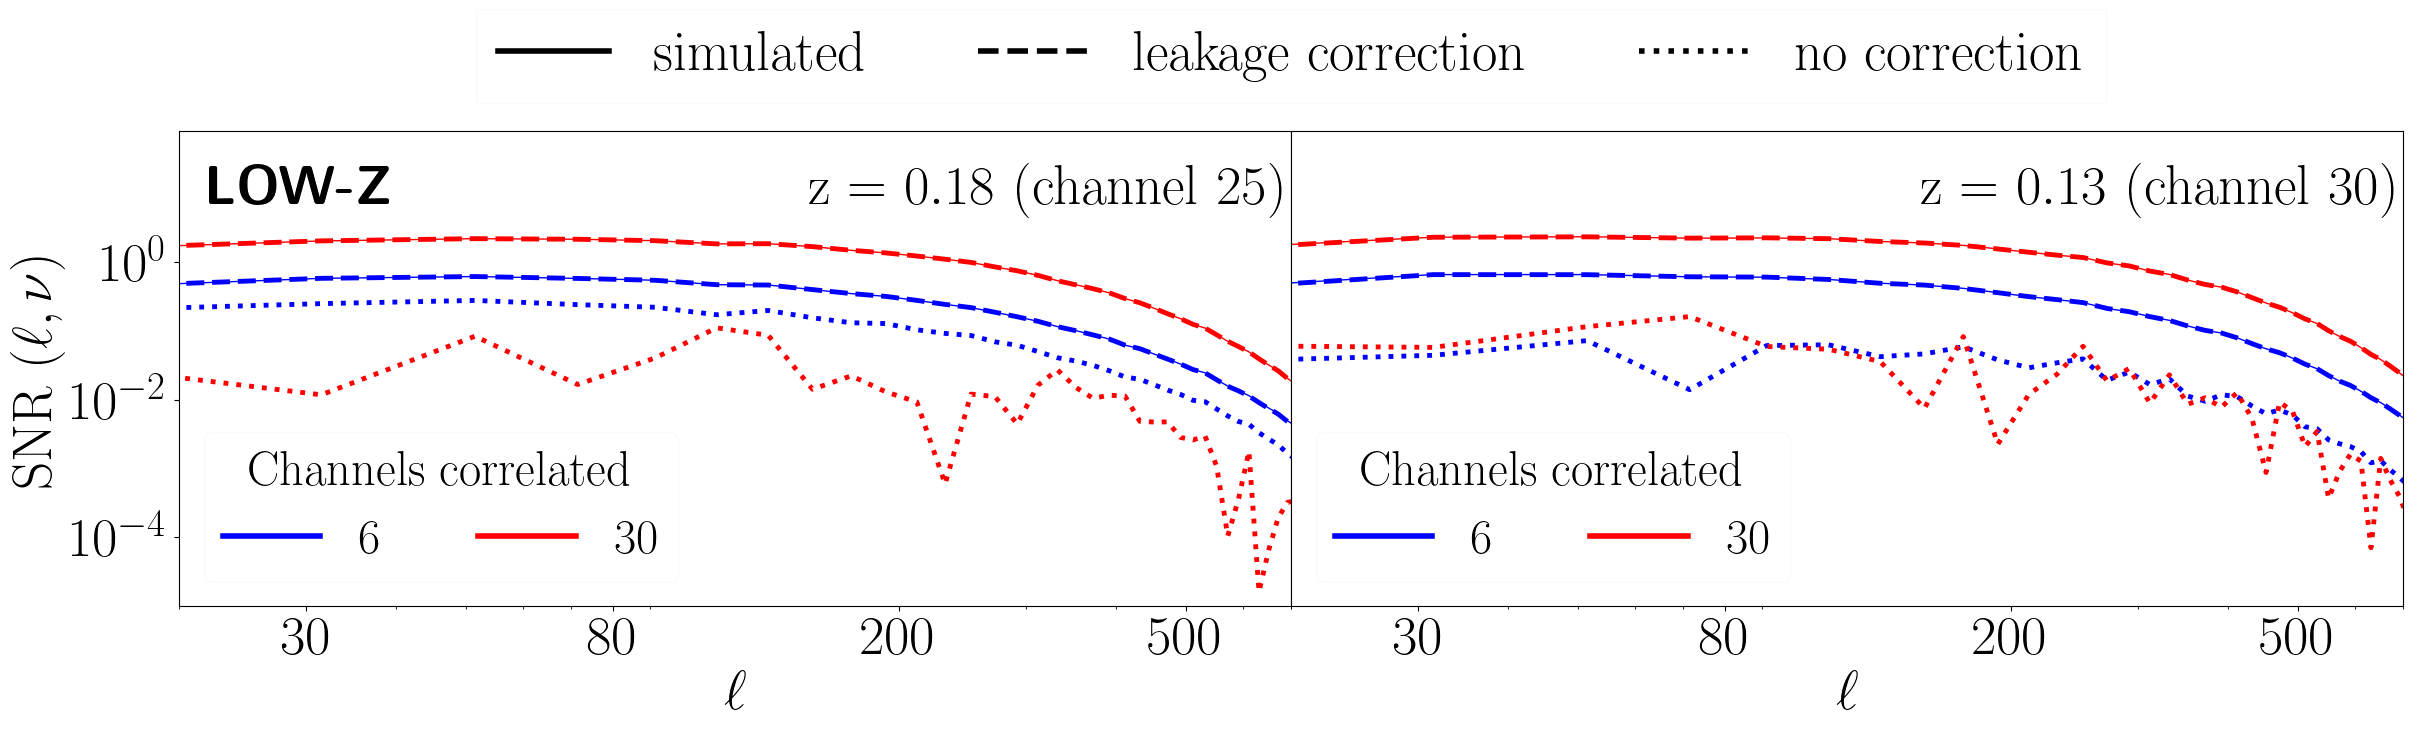

In [358]:
#fig, ax1 = plt.subplots(figsize=(14, 6))
fig   = plt.figure()
grid  = plt.GridSpec(1,2,top=1.1,right=3.6, wspace=0)
ncorr=30
############################################################################################################
# GALAXY ###################################################################################################
bins_plot=np.arange(24,30,1)
for c,col_ in enumerate([0,-1]):    
    ax1 = plt.subplot(grid[0,c])
    #bins_ = np.arange(24,30,1)[col_]
    j=2
    #############################################
    SN = sn_lowz_gal_sim[col_,:]
    SN = np.sqrt(SN**2)
    ax1.plot(leff, SN, color=my_cmap(j), lw=1, ls='solid') 
    SN =sn_lowz_gal_rec0[col_,:]
    SN = np.sqrt(SN**2)
    ax1.plot(leff, SN, color=my_cmap(j), lw=3.5, ls='dotted') 
    SN =sn_lowz_gal_rec[col_,:] 
    SN = np.sqrt(SN**2)
    ax1.plot(leff, SN, color=my_cmap(j), lw=3.5, ls='dashed') 
    # CMB ######################################################################################################
    zeff = cxft.get_zeff(numin =980, numax =1260, nbands=nch, n_curves=nch)['zeff'][bins_plot][col_]
    j=3
    #############################################
    _col = dcopy(col_)
    col_ = bins_plot[_col]
    SN = sn_lowz_cmb_sim[col_,:] 
    SN = np.sqrt(SN**2)
    ax1.plot(leff, SN, color=my_cmap(j), lw=1, ls='solid') 
    SN = sn_lowz_cmb_rec0[col_,:]
    SN = np.sqrt(SN**2)
    ax1.plot(leff, SN, color=my_cmap(j), lw=3.5, ls='dotted') 
    SN = sn_lowz_cmb_rec[col_,:] 
    SN = np.sqrt(SN**2)
    ax1.plot(leff, SN, color=my_cmap(j), lw=3.5, ls='dashed') 
    ax1.axhline(y=0, ls='dashed', color='lightgrey')
    #############################################
    ax1.set_xscale('log'); ax1.set_yscale('log')
    ax1.set_xlabel(r"$\ell$" , fontsize=40)
    #ax1.set_ylabel(r"$\textrm{SNR } (\ell,\nu)$" , fontsize=35)
    ax1.tick_params(axis='both', labelsize=40)
    
    ax1.set_ylim(1e-5,8e1)
    ax1.set_xlim(20,700)
    cyticks = [1e-4,1e-2,1e0]
    cxticks = [30, 80 ,200,500]
    ax1.set_xticks(cxticks)
    if not c: 
        ax1.set_yticks(cyticks)
        ax1.set_ylabel(r"$\textrm{SNR } (\ell,\nu)$" , fontsize=40)
        ax1.text(x=22, y=7e-0, s=r'$\textbf{LOW-Z}$', fontdict=font_dict, size= 40)
    else:     
        ax1.set_yticks([])
        #ax1.set_ylabel(r"$\textrm{SNR } (\ell,\nu)$" , fontsize=35)
    ax1.set_xticklabels([r'${}$'.format(s) for s in cxticks]) 
    #############################################
    custom_lines = [Line2D([0], [0], color='blue', lw=4, ls='solid'),
                    Line2D([0], [0], color='red' , lw=4, ls='solid')]
    
    legend_2= ax1.legend(custom_lines, 
                         [r'${}$'.format(6), 
                          r'${}$'.format(30)],
                         fontsize=35,ncols=2,loc='lower left',
                         framealpha=0.1, title=r'$\textrm{Channels correlated}$', 
                         title_fontsize=35)
    ax1.text(x=700-550, y=7e-0, s=r'$\textrm{z = }$'+r'${}$ '.format(zeff) + r'$\textrm{(channel $' + r'{}'.format(bins_plot[_col]+1) + '$})$', fontdict=font_dict, size= 40)
#######################################################################    
ax1.add_artist(legend_2)
custom_lines = [Line2D([0], [0], color='black', lw=4, ls='solid'),
                Line2D([0], [0], color='black', lw=4, ls='dashed'),
                Line2D([0], [0], color='black', lw=4, ls='dotted')]

legend_1= ax1.legend(custom_lines, [r'$\textrm{simulated}$', 
                                    r'$\textrm{leakage correction}$',
                                    r'$\textrm{no correction}$'],
         ncols=3, fontsize=40, loc='lower center',framealpha=0.1, fancybox=False,
         bbox_to_anchor=(-0., 1.),  shadow=False,)#edgecolor='lightblue', 

###########################################################
pathname = os.path.join( '/data/AMARINS/CMBWLxHI-CODES/images', '_'.join(( prefix,'.'.join(('SN_comparison_model2'.format(bins_plot),'png')) )) )
if 1: plt.savefig(pathname, dpi=100, bbox_inches='tight')
pathname

In [317]:
############################################
bins_plot=np.arange(24,30,1)
print('------------------')
print('LOWZ ---- (NS: {})'.format(ins.split('ns')[1]))
print('------------------')
for c,col_ in enumerate([0,-1]):    
    print('channel {}'.format(bins_plot[col_]))
    #############################################
    SN = sn_lowz_gal_sim[col_,:]
    SN = np.sqrt(np.sum( SN**2,axis=0))
    print('Gal -  sim: {:.2f}'.format(SN))
    SN =sn_lowz_gal_rec0[col_,:]
    SN = np.sqrt(np.sum( SN**2,axis=0))
    print('Gal - rec0: {:.2f}'.format(SN))
    SN =sn_lowz_gal_rec[col_,:] 
    SN = np.sqrt(np.sum( SN**2,axis=0))
    print('Gal - drec: {:.2f}'.format(SN))    
    
    # CMB ######################################################################################################
    #############################################
    _col = dcopy(col_)
    col_ = bins_plot[_col]
    SN = sn_lowz_cmb_sim[col_,:] 
    SN = np.sqrt(np.sum( SN**2,axis=0))
    print('CMB -  sim: {:.2f}'.format(SN))
    SN = sn_lowz_cmb_rec0[col_,:]
    SN = np.sqrt(np.sum( SN**2,axis=0))
    print('CMB - rec0: {:.2f}'.format(SN))
    SN = sn_lowz_cmb_rec[col_,:] 
    SN = np.sqrt(np.sum( SN**2,axis=0))
    print('CMB - drec: {:.2f}'.format(SN))
    print()


------------------
LOWZ ---- (NS: 4)
------------------
channel 24
Gal -  sim: 1.62
Gal - rec0: 0.67
Gal - drec: 1.62
CMB -  sim: 6.32
CMB - rec0: 0.18
CMB - drec: 6.33

channel 29
Gal -  sim: 1.79
Gal - rec0: 0.18
Gal - drec: 1.79
CMB -  sim: 7.02
CMB - rec0: 0.26
CMB - drec: 7.00



In [318]:
#############################################################
lkg_field  = 'gal'
type_field = 'gal'
hi_regime  = 'lowz'
Nk = dcopy(Nkgal); blg_k = dcopy(blg_kgal); Cl_wn = dcopy(Cl_wn_lowz)
bins_ = bins_highz = np.arange(24,30,1)
SN_lowz_gal_sim  = SN_per_nu_mean(ins_=ins, clcx_=clcx_lowz, bins_=bins_, NS=['ns3','ns4','ns5'],
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field = type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_sim_sim', f1_label='cl_f1_sim', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

SN_lowz_gal_rec0 = SN_per_nu_mean(ins_=ins, clcx_=clcx_lowz, bins_=bins_, NS=['ns3','ns4','ns5'],
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_rec', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

SN_lowz_gal_rec  = SN_per_nu_mean(ins_=ins, clcx_=clcx_lowz, bins_=bins_, NS=['ns3','ns4','ns5'],
                                    leakage=True, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_rec', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)
#############################################################
lkg_field  = 'cmb'
type_field = 'cmb'
hi_regime  = 'lowz'
Nk = dcopy(Nkcmb); blg_k = dcopy(blg_kcmb); Cl_wn = dcopy(Cl_wn_lowz)
bins_ = bins_highz = np.arange(0,30,1)
SN_lowz_cmb_sim  = SN_per_nu_mean(ins_=ins, clcx_=clcx_lowz, bins_=bins_, NS=['ns3','ns4','ns5'],
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field = type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_sim_sim', f1_label='cl_f1_sim', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

SN_lowz_cmb_rec0 = SN_per_nu_mean(ins_=ins, clcx_=clcx_lowz, bins_=bins_, NS=['ns3','ns4','ns5'],
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_rec', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

SN_lowz_cmb_rec  = SN_per_nu_mean(ins_=ins, clcx_=clcx_lowz, bins_=bins_, NS=['ns3','ns4','ns5'],
                                    leakage=True, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_rec', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

In [319]:
print('LOW-Z')
print('========= GAL =========')
for ins in ['ns3','ns4','ns5']:
    print('{}:  NO/YES/SIM:  {:.1f} / {:.1f} / {:.1f}'.format(ins,  np.sqrt(np.sum(SN_lowz_gal_rec0[ins]**2)), np.sqrt(np.sum(SN_lowz_gal_rec[ins]**2)), np.sqrt(np.sum(SN_lowz_gal_sim[ins]**2)) ) )
############################
print('========= CMB =========')
for ins in ['ns3','ns4','ns5']:
    print('{}:  NO/YES/SIM:  {:.1f} / {:.1f} / {:.1f}'.format(ins,  np.sqrt(np.sum(SN_lowz_cmb_rec0[ins]**2)), np.sqrt(np.sum(SN_lowz_cmb_rec[ins]**2)), np.sqrt(np.sum(SN_lowz_cmb_sim[ins]**2)) ) )   

LOW-Z
========= GAL =========
ns3:  NO/YES/SIM:  1.1 / 4.4 / 4.2
ns4:  NO/YES/SIM:  1.1 / 4.4 / 4.2
ns5:  NO/YES/SIM:  1.1 / 4.4 / 4.2
========= CMB =========
ns3:  NO/YES/SIM:  1.2 / 28.7 / 27.9
ns4:  NO/YES/SIM:  1.2 / 29.0 / 27.9
ns5:  NO/YES/SIM:  1.2 / 29.7 / 27.9


In [320]:
print('{:.2f}'.format(np.sqrt(np.sum(sn_lowz_gal_sim**2))) )
print('{:.2f}'.format(np.sqrt(np.sum(sn_lowz_gal_rec0**2))) )
print('{:.2f}'.format(np.sqrt(np.sum(sn_lowz_gal_rec**2))) )

4.16
1.10
4.16


In [321]:
print('{:.2f}'.format(np.sqrt(np.sum(sn_lowz_cmb_sim**2))) )
print('{:.2f}'.format(np.sqrt(np.sum(sn_lowz_cmb_rec0**2))) )
print('{:.2f}'.format(np.sqrt(np.sum(sn_lowz_cmb_rec**2))) )

27.87
1.12
27.73


## HIGHZ

In [322]:
#########################################
### THEORETICAL
nside  = 256
prefix = 'highz'
suffix = 'nch70_350_1050'
##########################################
filepath_cross  = '/data/AMARINS/CMBWLxHI-DATA/theoretical/{}_CMBWLxHI_cl_{}.txt'.format(prefix, suffix)  
#########################################
clcx_highz = np.loadtxt(filepath_cross ).T[1:,:] 
nch  = int(clcx_highz.shape[0])
prefix ='_'.join(( prefix,suffix ))

In [323]:
prefix

'highz_nch70_350_1050'

In [324]:
#prefix = 'lowz_nch30_980_1260'
dirpath_out = '/data/AMARINS/CMBWLxHI-DATA/postprocessed/fullsky/{}'.format(prefix)
sim_names = []
for j,jsim in enumerate(np.sort( np.asarray( os.listdir(os.path.join(dirpath_out,'ns3','cross','')) ) )):
    if 'sim' in jsim:
        sim_names.append(jsim)
sim_names = np.asarray(sim_names)   

In [325]:
###########################################################################################
######## NOISE
### HIGH-Z 
output_info = {"frequency":{"min":350,"max":1050,'nbands':70},
               'nside':256, "savedata_hdu" : 1}
nu_vec_highz = hdata.nu_bins_vector(numin_ =output_info['frequency']['min'], 
                                    numax_ =output_info['frequency']['max'], 
                                   nbands_=output_info['frequency']['nbands'])['nu']
nuvec_highz_eff = np.array([ 0.5*(nu_vec_highz[i]+nu_vec_highz[i+1]) for i in range(nu_vec_highz.size-1) ])
for jch in range(nuvec_highz_eff.size):
    sigma_info = {'nside' :output_info['nside'],
                  'nbeams':425,#int(197*(64800/30000))
                  'Osur'  :64800,#5324,
                  'Obeam' :np.pi*(2/2)**2, #pi*(FWHM/2)^2
                  'tsur'  :1,
                  'K'     :1,#2**(1/2),
                  'fsky'  :1,#0.13,
                  'dcycle':1,
                  'output_unit':'mK'}#0.9}    
    sigma_info['nch']   =70
    sigma_info['nu_min']=nu_vec_highz[jch]
    sigma_info['nu_max']=nu_vec_highz[jch+1]
    sigma_info['nu_eff']=nuvec_highz_eff[jch] 
    sigma_info['Tsys']=fnoise.Tsys_SKA_MID_band1(nuvec_highz_eff[jch])#K
    gnoise = hdata.get_noise_level(sigma_info)
    jwn = np.random.normal(scale = gnoise['sigmaN'], size=(1,12*sigma_info['nside']**2))
    cl_jwn = hp.anafast(jwn,pol=False)
    WN_highz = jwn if not jch else np.vstack(( WN_highz,jwn ))
    Cl_wn_highz  = cl_jwn if not jch else np.vstack(( Cl_wn_highz,cl_jwn ))
    del jwn, cl_jwn    

In [326]:
###########################################################################################
### CMB CONVERGENCE (CMB-S4)
path_cmbk = '/home/amarins/fullsky.xlsx'
Ncmbk_tab = pd.read_excel(path_cmbk, index_col=None, header=None) #[l, ((l(l+1))^2/2pi)Cl ]
Nkcmb = np.hstack((Ncmbk_tab[1].values[0],Ncmbk_tab[1].values[0],Ncmbk_tab[1].values))
lcmb = np.arange(Nkcmb.size)
###########################################################################################
### GAL CONVERGENCE (LSST)
nu_min = 64
nu_max = 69
bins   = np.arange(nu_min,nu_max+1)
sigma_eps_2 = 0.26
Nbins = bins.size 
ngal  = 27        #gal/arcmin2
Apix  = 5.49      #arcmin2
sigma2   = sigma_eps_2/(ngal/Apix/Nbins) #standard deviation ~ N(0,sgm)
WN_kappa = np.random.normal(scale = np.sqrt(sigma2), size=(Nbins,12*nside**2))
Nkgal    = np.zeros_like(Cl_wn_highz)
kch=0
for jch in range(WN_highz.shape[0]):
    if jch in bins:
        Nkgal[jch] = hp.anafast(WN_kappa[kch], pol=False)
        kch+=1
l=np.arange(Cl_wn_highz[0].size)
#############################################################################################
######## BEAMS
blg_hi   = fnoise.bl_function(2, input_unit="degree", from_real_space=False)[:-1]
blg_kgal = fnoise.bl_function(np.sqrt(5.49)/60, input_unit="degree", from_real_space=False)[:-1]
blg_kcmb = fnoise.bl_function(10/60, input_unit="degree", from_real_space=False)[:-1]

In [327]:
ins='ns4'
#############################################################
lkg_field  = 'gal'
type_field = 'gal'
hi_regime  = 'highz'
Nk    = dcopy(Nkgal); blg_k = dcopy(blg_kgal); Cl_wn = dcopy(Cl_wn_highz)
bins_ = np.arange(64,70,1)
sn_highz_gal_sim = SN_per_ell_per_nu_mean(ins_=ins, clcx_=clcx_highz, bins_=bins_,
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field = type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_sim_sim', f1_label='cl_f1_sim', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

sn_highz_gal_rec0= SN_per_ell_per_nu_mean(ins_=ins, clcx_=clcx_highz, bins_=bins_,
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_sim', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

sn_highz_gal_rec = SN_per_ell_per_nu_mean(ins_=ins, clcx_=clcx_highz, bins_=bins_,
                                    leakage=True, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_sim', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)
#############################################################
lkg_field  = 'cmb'
type_field = 'cmb'
hi_regime  = 'highz'
Nk    = dcopy(Nkcmb); blg_k = dcopy(blg_kcmb); Cl_wn = dcopy(Cl_wn_highz)
bins_ = np.arange(0,70,1)
sn_highz_cmb_sim = SN_per_ell_per_nu_mean(ins_=ins, clcx_=clcx_highz, bins_=bins_,
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field = type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_sim_sim', f1_label='cl_f1_sim', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

sn_highz_cmb_rec0= SN_per_ell_per_nu_mean(ins_=ins, clcx_=clcx_highz, bins_=bins_,
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_sim', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

sn_highz_cmb_rec = SN_per_ell_per_nu_mean(ins_=ins, clcx_=clcx_highz, bins_=bins_,
                                    leakage=True, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_sim', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

'/data/AMARINS/CMBWLxHI-CODES/images/lowz_nch30_980_1260_SN_comparison_model2.png'

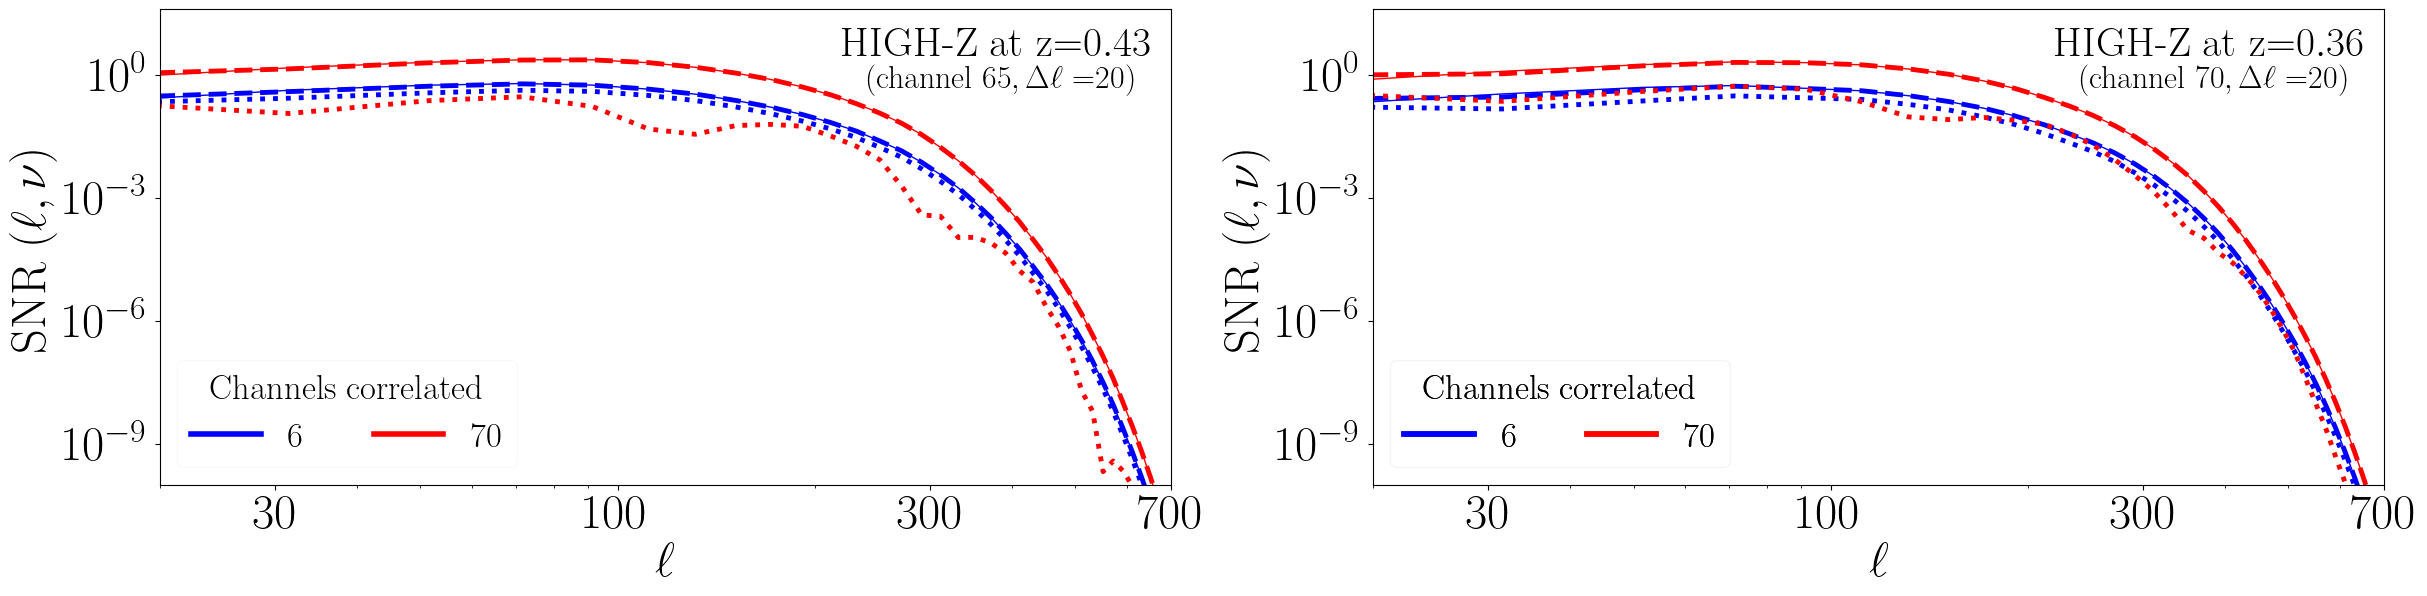

In [204]:
#fig, ax1 = plt.subplots(figsize=(14, 6))
fig   = plt.figure()
grid  = plt.GridSpec(1,2,top=1.1,right=3.6, wspace=0.2)
############################################################################################################
# GALAXY ###################################################################################################
bins_plot   = np.arange(64,69+1,1)
for c,col_ in enumerate([0,-1]):    
    ax1 = plt.subplot(grid[0,c])
    #bins_plot = bins[col_]
    j=2
    #############################################
    SN = sn_highz_gal_sim[col_,:]
    SN = np.sqrt(SN**2)
    ax1.plot(leff, SN, color=my_cmap(j), lw=1, ls='solid') 
    SN =sn_highz_gal_rec0[col_,:]
    SN = np.sqrt(SN**2)
    ax1.plot(leff, SN, color=my_cmap(j), lw=3.5, ls='dotted') 
    SN =sn_highz_gal_rec[col_,:] 
    SN = np.sqrt(SN**2)
    ax1.plot(leff, SN, color=my_cmap(j), lw=3.5, ls='dashed') 
    # CMB ######################################################################################################
    zeff = cxft.get_zeff(numin =350, numax =1050, nbands=nch, n_curves=nch)['zeff'][bins_plot][col_]
    j=3
    #############################################
    _col = dcopy(col_)
    col_ = bins_plot[_col]
    SN = sn_highz_cmb_sim[col_,:] 
    SN = np.sqrt(SN**2)
    ax1.plot(leff, SN, color=my_cmap(j), lw=1, ls='solid') 
    SN = sn_highz_cmb_rec0[col_,:]
    SN = np.sqrt(SN**2)
    ax1.plot(leff, SN, color=my_cmap(j), lw=3.5, ls='dotted') 
    SN = sn_highz_cmb_rec[col_,:] 
    SN = np.sqrt(SN**2)
    ax1.plot(leff, SN, color=my_cmap(j), lw=3.5, ls='dashed') 
    ax1.axhline(y=0, ls='dashed', color='lightgrey')
    #############################################
    ax1.set_xscale('log'); ax1.set_yscale('log')
    ax1.set_xlabel(r"$\ell$" , fontsize=35)
    ax1.set_ylabel(r"$\textrm{SNR } (\ell,\nu)$" , fontsize=35)
    ax1.tick_params(axis='both', labelsize=35)
    
    ax1.set_ylim(1e-10,4e1)
    ax1.set_xlim(20,700)
    cyticks = [1e-9,1e-6,1e-3,1e0]
    cxticks = [30, 100,300,700]
    ax1.set_yticks(cyticks)
    ax1.set_xticks(cxticks)
    ax1.set_xticklabels([r'${}$'.format(s) for s in cxticks]) 
    #############################################
    custom_lines = [Line2D([0], [0], color='blue', lw=4, ls='solid'),
                    Line2D([0], [0], color='red' , lw=4, ls='solid')]
    
    legend_2= ax1.legend(custom_lines, 
                         [r'${}$'.format(6), 
                          r'${}$'.format(nch)],
                         fontsize=25,ncols=2,loc='lower left',
                         framealpha=0.1, title=r'$\textrm{Channels correlated}$', 
                         title_fontsize=25)

    ax1.text(x=700-480, y=3e-0, s=r'$\textrm{HIGH-Z at z=}$'+r'${}$'.format(zeff), fontdict=font_dict)
    ax1.text(x=700-460, y=0.5e-0,  s=r'$\textrm{(channel $' + r'{}'.format(bins_plot[_col]+1) + '$}, \Delta\ell =$' + r'${})$'.format(del_l), fontdict=font_dict, size=23)
#######################################################################    
###########################################################
ax1.add_artist(legend_2)
custom_lines = [Line2D([0], [0], color='black', lw=4, ls='solid'),
                Line2D([0], [0], color='black', lw=4, ls='dashed'),
                Line2D([0], [0], color='black', lw=4, ls='dotted')]

#legend_1= ax1.legend(custom_lines, [r'$\textrm{simulated}$', 
          #                          r'$\textrm{leakage correction}$',
           #                         r'$\textrm{no correction}$'],
         #ncols=3, fontsize=40, loc='lower center',framealpha=0.1, fancybox=False,
#         bbox_to_anchor=(-0.1, 1.),  shadow=False,)#edgecolor='lightblue', 

###########################################################
pathname = os.path.join( '/data/AMARINS/CMBWLxHI-CODES/images', '_'.join(( prefix,'.'.join(('SN_comparison_model2'.format(bins_plot),'png')) )) )
#if 1: plt.savefig(pathname, dpi=100, bbox_inches='tight')
pathname

'/data/AMARINS/CMBWLxHI-CODES/images/highz_nch70_350_1050_SN_comparison_model2.png'

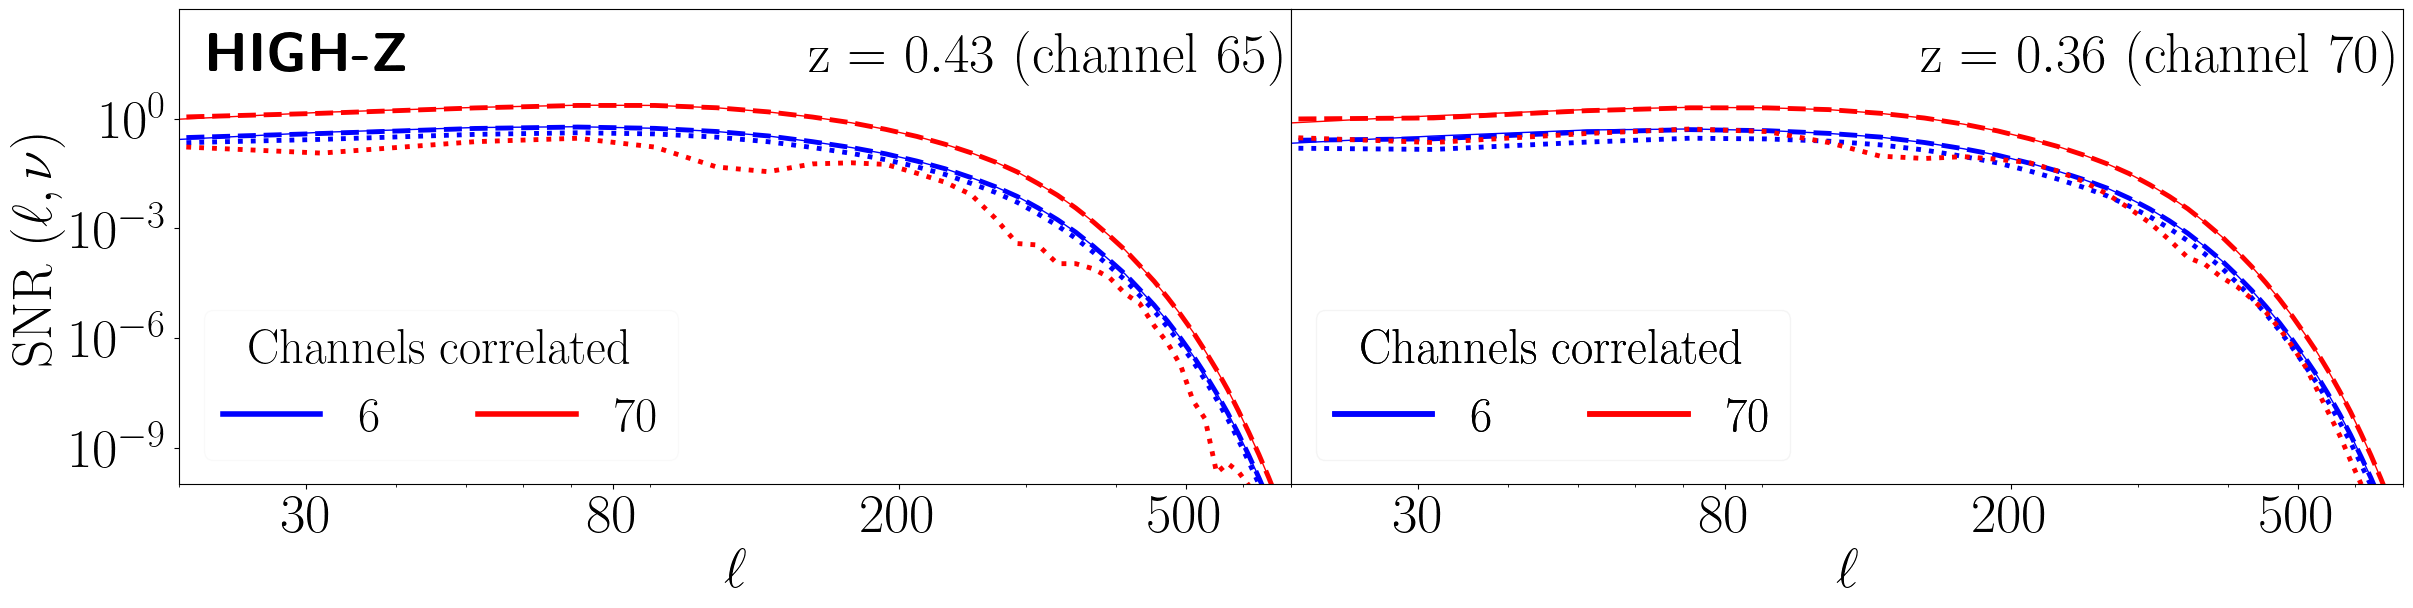

In [349]:
#fig, ax1 = plt.subplots(figsize=(14, 6))
fig   = plt.figure()
grid  = plt.GridSpec(1,2,top=1.1,right=3.6, wspace=0.0)
############################################################################################################
# GALAXY ###################################################################################################
bins_plot   = np.arange(64,69+1,1)
for c,col_ in enumerate([0,-1]):    
    ax1 = plt.subplot(grid[0,c])
    #bins_plot = bins[col_]
    j=2
    #############################################
    SN = sn_highz_gal_sim[col_,:]
    SN = np.sqrt(SN**2)
    ax1.plot(leff, SN, color=my_cmap(j), lw=1, ls='solid') 
    SN =sn_highz_gal_rec0[col_,:]
    SN = np.sqrt(SN**2)
    ax1.plot(leff, SN, color=my_cmap(j), lw=3.5, ls='dotted') 
    SN =sn_highz_gal_rec[col_,:] 
    SN = np.sqrt(SN**2)
    ax1.plot(leff, SN, color=my_cmap(j), lw=3.5, ls='dashed') 
    # CMB ######################################################################################################
    zeff = cxft.get_zeff(numin =350, numax =1050, nbands=nch, n_curves=nch)['zeff'][bins_plot][col_]
    j=3
    #############################################
    _col = dcopy(col_)
    col_ = bins_plot[_col]
    SN = sn_highz_cmb_sim[col_,:] 
    SN = np.sqrt(SN**2)
    ax1.plot(leff, SN, color=my_cmap(j), lw=1, ls='solid') 
    SN = sn_highz_cmb_rec0[col_,:]
    SN = np.sqrt(SN**2)
    ax1.plot(leff, SN, color=my_cmap(j), lw=3.5, ls='dotted') 
    SN = sn_highz_cmb_rec[col_,:] 
    SN = np.sqrt(SN**2)
    ax1.plot(leff, SN, color=my_cmap(j), lw=3.5, ls='dashed') 
    ax1.axhline(y=0, ls='dashed', color='lightgrey')
    #############################################
    ax1.set_xscale('log'); ax1.set_yscale('log')
    ax1.set_xlabel(r"$\ell$" , fontsize=40)
    ax1.tick_params(axis='both', labelsize=40)
    
    ax1.set_ylim(1e-10, 1e3)
    ax1.set_xlim(20,700)
    cyticks = [1e-9,1e-6,1e-3,1e0]
    cxticks = [30, 80 ,200,500]
    ax1.set_xticks(cxticks)
    if not c: 
        ax1.set_yticks(cyticks)
        ax1.set_ylabel(r"$\textrm{SNR } (\ell,\nu)$" , fontsize=40)
        ax1.text(x=22, y=2e1, s=r'$\textbf{HIGH-Z}$', fontdict=font_dict, size=40)
    else:     
        ax1.set_yticks([])
        #ax1.set_ylabel(r"$\textrm{SNR } (\ell,\nu)$" , fontsize=35)
    ax1.set_xticklabels([r'${}$'.format(s) for s in cxticks]) 
    #############################################
    custom_lines = [Line2D([0], [0], color='blue', lw=4, ls='solid'),
                    Line2D([0], [0], color='red' , lw=4, ls='solid')]
    
    legend_2= ax1.legend(custom_lines, 
                         [r'${}$'.format(6), 
                          r'${}$'.format(nch)],
                         fontsize=35,ncols=2,loc='lower left',
                         framealpha=0.1, title=r'$\textrm{Channels correlated}$', 
                         title_fontsize=35)
    ax1.text(x=700-550, y=2e1, s=r'$\textrm{z = }$'+r'${}$ '.format(zeff) + r'$\textrm{(channel $' + r'{}'.format(bins_plot[_col]+1) + '$})$', fontdict=font_dict, size=40)
    #ax1.text(x=700-460, y=0.5e-0,  s=r'$\textrm{(channel $' + r'{}'.format(bins_plot[_col]+1) + '$}, \Delta\ell =$' + r'${})$'.format(del_l), fontdict=font_dict, size=23)
#######################################################################    
###########################################################
ax1.add_artist(legend_2)
custom_lines = [Line2D([0], [0], color='black', lw=4, ls='solid'),
                Line2D([0], [0], color='black', lw=4, ls='dashed'),
                Line2D([0], [0], color='black', lw=4, ls='dotted')]

#legend_1= ax1.legend(custom_lines, [r'$\textrm{simulated}$', 
          #                          r'$\textrm{leakage correction}$',
           #                         r'$\textrm{no correction}$'],
         #ncols=3, fontsize=40, loc='lower center',framealpha=0.1, fancybox=False,
#         bbox_to_anchor=(-0.1, 1.),  shadow=False,)#edgecolor='lightblue', 

###########################################################
pathname = os.path.join( '/data/AMARINS/CMBWLxHI-CODES/images', '_'.join(( prefix,'.'.join(('SN_comparison_model2'.format(bins_plot),'png')) )) )
if 1: plt.savefig(pathname, dpi=100, bbox_inches='tight')
pathname

In [350]:
#############################################################
lkg_field  = 'gal'
type_field = 'gal'
hi_regime  = 'highz'
Nk = dcopy(Nkgal); blg_k = dcopy(blg_kgal); Cl_wn = dcopy(Cl_wn_highz)
#bins_highz = np.arange(64,70,1)
bins_ = np.arange(64,70,1)
SN_highz_gal_sim  = SN_per_nu_mean(ins_=ins, clcx_=clcx_highz, bins_=bins_, NS=['ns3','ns4','ns5'],
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field = type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_sim_sim', f1_label='cl_f1_sim', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

SN_highz_gal_rec0 = SN_per_nu_mean(ins_=ins, clcx_=clcx_highz, bins_=bins_, NS=['ns3','ns4','ns5'],
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_rec', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

SN_highz_gal_rec  = SN_per_nu_mean(ins_=ins, clcx_=clcx_highz, bins_=bins_, NS=['ns3','ns4','ns5'],
                                    leakage=True, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_rec', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)
#############################################################
lkg_field  = 'cmb'
type_field = 'cmb'
hi_regime  = 'highz'
Nk = dcopy(Nkcmb); blg_k = dcopy(blg_kcmb); Cl_wn = dcopy(Cl_wn_highz)
#bins_highz = np.arange(0,70,1)
bins_ = np.arange(0,70,1)
SN_highz_cmb_sim  = SN_per_nu_mean(ins_=ins, clcx_=clcx_highz, bins_=bins_, NS=['ns3','ns4','ns5'],
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field = type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_sim_sim', f1_label='cl_f1_sim', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

SN_highz_cmb_rec0 = SN_per_nu_mean(ins_=ins, clcx_=clcx_highz, bins_=bins_, NS=['ns3','ns4','ns5'],
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_rec', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

SN_highz_cmb_rec  = SN_per_nu_mean(ins_=ins, clcx_=clcx_highz, bins_=bins_, NS=['ns3','ns4','ns5'],
                                    leakage=True, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_rec', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

In [351]:
print('HIGH-Z')
print('========= GAL =========')
for ins in ['ns3','ns4','ns5']:
    print('{}:  NO/YES/SIM:  {:.1f} / {:.1f} / {:.1f}'.format(ins,  np.sqrt(np.sum(SN_highz_gal_rec0[ins]**2)), np.sqrt(np.sum(SN_highz_gal_rec[ins]**2)), np.sqrt(np.sum(SN_highz_gal_sim[ins]**2)) ) )
############################
print('========= CMB =========')
for ins in ['ns3','ns4','ns5']:
    print('{}:  NO/YES/SIM:  {:.1f} / {:.1f} / {:.1f}'.format(ins,  np.sqrt(np.sum(SN_highz_cmb_rec0[ins]**2)), np.sqrt(np.sum(SN_highz_cmb_rec[ins]**2)), np.sqrt(np.sum(SN_highz_cmb_sim[ins]**2)) ) )   

HIGH-Z
========= GAL =========
ns3:  NO/YES/SIM:  0.7 / 0.8 / 2.9
ns4:  NO/YES/SIM:  1.8 / 2.7 / 2.9
ns5:  NO/YES/SIM:  1.0 / 1.5 / 2.9
========= CMB =========
ns3:  NO/YES/SIM:  5.2 / 21.2 / 47.6
ns4:  NO/YES/SIM:  2.6 / 47.5 / 47.6
ns5:  NO/YES/SIM:  1.8 / 21.2 / 47.6


In [352]:
SN_lowz_gal_sim[ins].shape, SN_lowz_cmb_sim[ins].shape

((6,), (30,))

'/data/AMARINS/CMBWLxHI-CODES/images/SN_comparison_overall_z_model2.png'

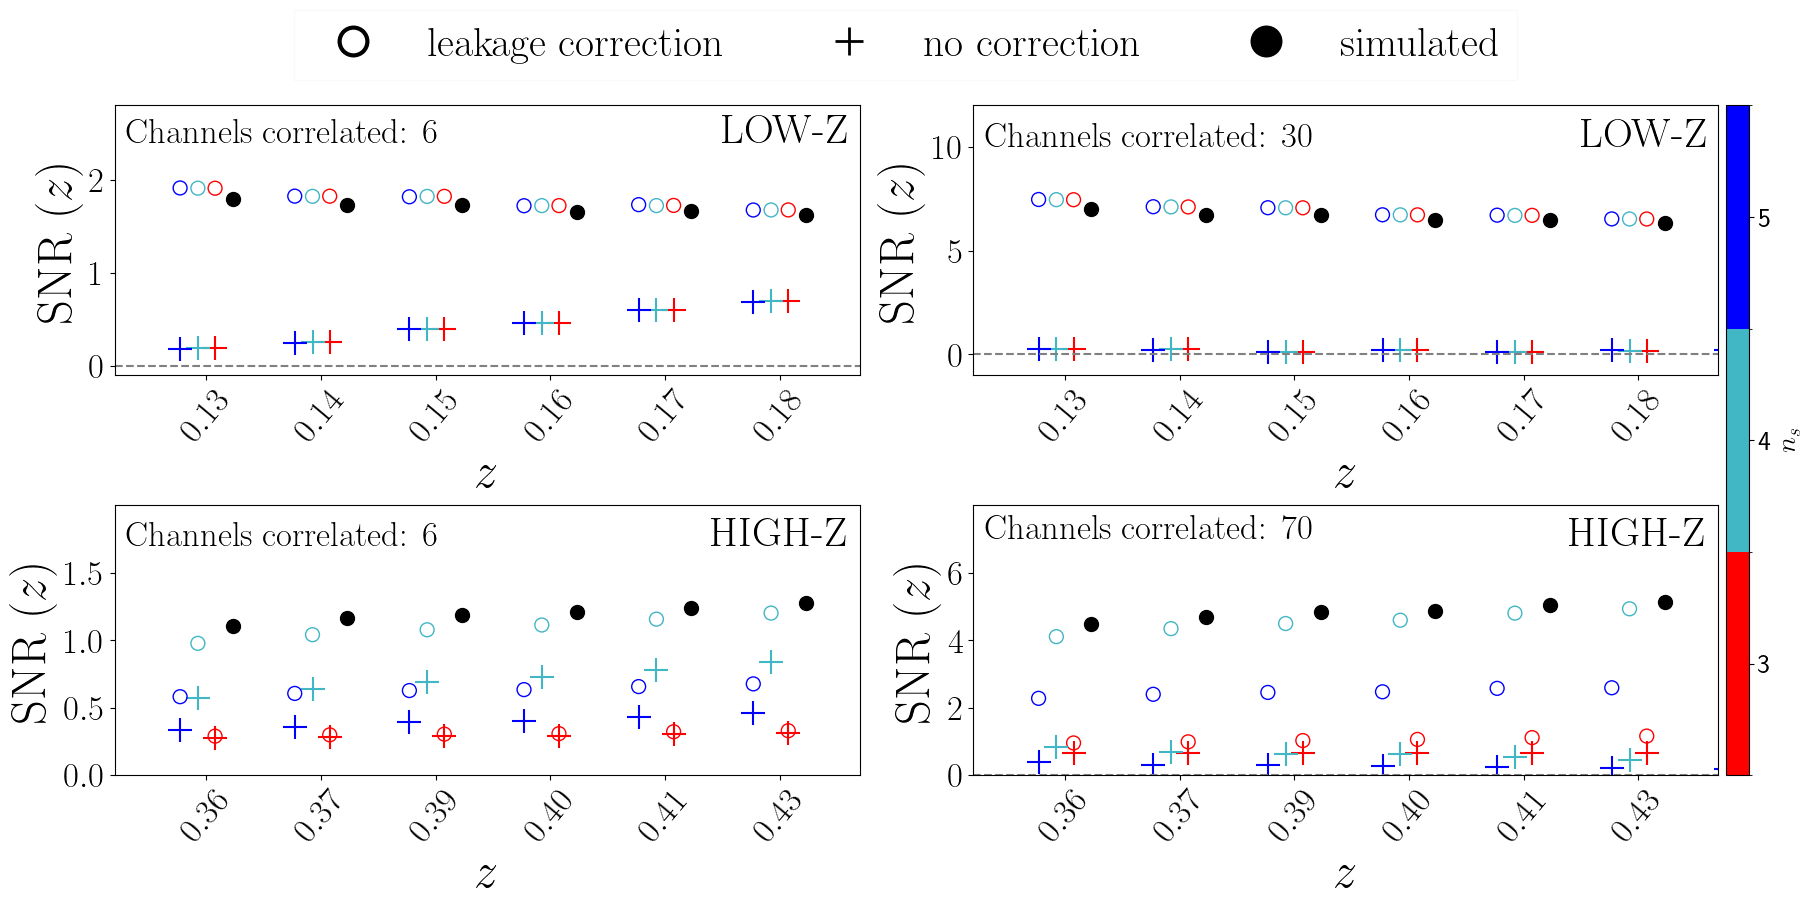

In [353]:
#fig   = plt.figure()
#grid  = plt.GridSpec(2,2,top=2*1.2,right=2*1.6,wspace=0.2, hspace=0.0)
fig, axes = plt.subplots(2,2,layout='constrained', figsize=(18, 8))
###############}
c    = np.arange(3, 5+1, dtype=np.int8)
#cmap = plt.get_cmap("terrain", 10)
my_cmap2 = ListedColormap( ['#ff0000', "#41b6c4", '#0000ff'], name="my_cmap2")
cmap = plt.get_cmap(my_cmap2)
norm = mpl.colors.BoundaryNorm(np.arange(len(c)+1)+0.5,len(c))
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([]) 
######################################################################################################################
# LOWZ ##########################################################
fsky=1
shift = [-0.23,-0.075,0.075,0.23]
#bins_lowz = np.arange(24,30,1)
#bins_ = dcopy(bins_lowz)
for j, (bins_,SN_nu_sim_dict, SN_nu_rec_dict, SN_nu_rec0_dict) in enumerate(zip([np.arange(24,30,1), np.arange(0,30,1)],
                                                                          [SN_lowz_gal_sim, SN_lowz_cmb_sim],
                                                                          [SN_lowz_gal_rec, SN_lowz_cmb_rec],
                                                                          [SN_lowz_gal_rec0,SN_lowz_cmb_rec0])):
    ax    = axes[0,j]#plt.subplot(grid[0,j])
    for j, ins in enumerate(['ns3','ns4','ns5']):
        sn_rec  = dcopy(SN_nu_rec_dict[ins])
        sn_rec0 = dcopy(SN_nu_rec0_dict[ins])
        ax.scatter( bins_+1 +shift[j+1], sn_rec , marker='o', color=cmap(j),s=100,facecolor='none',)#,  markersize=8, capsize=5, markeredgecolor='black',markeredgewidth=0.4)#fillstyle='top',**filled_marker_style)
        ax.scatter( bins_+1 +shift[j+1], sn_rec0, marker='+', color=cmap(j),s=300)#,  markersize=8, capsize=5, markerfacecolor='none' ,markeredgewidth=0.9)
        ########    
    sn_sim  = dcopy(SN_nu_sim_dict['ns3'])
    ax.scatter( bins_+1-shift[j+1], sn_sim, marker='o', color='black',s=100)
    ax.set_xscale('linear'); ax.set_yscale('linear'); 
    ax.set_xlabel(r"$z$" , fontsize=35)
    ax.set_ylabel(r"$\textrm{SNR }(z)$" , fontsize=35)    
    ax.tick_params(axis='both', labelsize=25)#labelcolor='in
###########################################################
zeff = cxft.get_zeff(numin =980, numax =1260, nbands=30, n_curves=30)['zeff']

axes[0,0].set_ylim(-0.1, 2.8)
axes[0,0].set_xlim(24.3,30.8)
axes[0,0].set_yticks([0,1,2])
axes[0,0].set_xticks(bins_[24:]+1, [r'${:.2f}$'.format(z) for z in zeff[24:]], rotation =50)

axes[0,1].set_ylim(-1, 12)
axes[0,1].set_xlim(24.3,30.8)
axes[0,1].set_yticks([0,5,10])
axes[0,1].set_xticks(bins_[24:]+1, [r'${:.2f}$'.format(z) for z in zeff[24:]], rotation =50)

ncorr=6
axes[0,0].text(x=30.7, y=2.4,s=r'$\textrm{Channels correlated: }$'+r'${}$'.format(ncorr), fontdict=font_dict, size=25)
#axes[0,0].text(x=30.1, y=2.4, s=r'$(\Delta\ell = $'+r'${})$'.format(del_l), fontdict=font_dict, size=25)
axes[0,0].text(x=25.5, y=2.4,s=r'$\textrm{LOW-Z}$', fontdict=font_dict)
ncorr=30
axes[0,1].text(x=30.7, y=10,s=r'$\textrm{Channels correlated: }$'+r'${}$'.format(ncorr), fontdict=font_dict, size=25)
#axes[0,1].text(x=30.1, y=36, s=r'$(\Delta\ell = $'+r'${})$'.format(del_l), fontdict=font_dict, size=25)
axes[0,1].text(x=25.5, y=10,s=r'$\textrm{LOW-Z}$', fontdict=font_dict)
#ax.axhline(y=0, ls='dashed', color='lightgrey')

######################################################################################################################
# HIGHZ ##########################################################
fsky=1
shift = [-0.23,-0.075,0.075,0.23]
#bins_highz = np.arange(64,70,1)
#bins_ = dcopy(bins_highz)
for j, (bins_,SN_nu_sim_dict, SN_nu_rec_dict, SN_nu_rec0_dict) in enumerate(zip([np.arange(64,70,1),np.arange(0,70,1)],
                                                                          [SN_highz_gal_sim, SN_highz_cmb_sim],
                                                                          [SN_highz_gal_rec, SN_highz_cmb_rec],
                                                                          [SN_highz_gal_rec0,SN_highz_cmb_rec0])):
    ax    = axes[1,j]#plt.subplot(grid[0,j])
    for j, ins in enumerate(['ns3','ns4','ns5']):
        sn_rec  = dcopy(SN_nu_rec_dict[ins])
        sn_rec0 = dcopy(SN_nu_rec0_dict[ins])
        ax.scatter( bins_+1 +shift[j+1], sn_rec , marker='o', color=cmap(j),s=100,facecolor='none',)#,  markersize=8, capsize=5, markeredgecolor='black',markeredgewidth=0.4)#fillstyle='top',**filled_marker_style)
        ax.scatter( bins_+1 +shift[j+1], sn_rec0, marker='+', color=cmap(j),s=300)#,  markersize=8, capsize=5, markerfacecolor='none' ,markeredgewidth=0.9)
        ########    
    sn_sim  = dcopy(SN_nu_sim_dict['ns3'])
    ax.scatter( bins_+1-shift[j+1], sn_sim, marker='o', color='black',s=100)
    ax.set_xscale('linear'); ax.set_yscale('linear'); 
    ax.set_xlabel(r"$z$" , fontsize=35)
    ax.set_ylabel(r"$\textrm{SNR }(z)$" , fontsize=35)    
    ax.tick_params(axis='both', labelsize=25)#labelcolor='in
###########################################################
zeff = cxft.get_zeff(numin =350, numax =1050, nbands=70, n_curves=70)['zeff']

axes[1,0].set_ylim(0, 2)
axes[1,0].set_xlim(64.3,70.8)
axes[1,0].set_yticks([ 0, 0.5,1,1.5])
axes[1,0].set_xticks(bins_[64:]+1, [r'${:.2f}$'.format(z) for z in zeff[64:]], rotation =50)

axes[1,1].set_ylim(0, 8)
axes[1,1].set_xlim(64.3,70.8)
axes[1,1].set_yticks([0,2,4,6])
axes[1,1].set_xticks(bins_[64:]+1, [r'${:.2f}$'.format(z) for z in zeff[64:]], rotation =50)

ncorr=6
axes[1,0].text(x=70.7, y=1.7,s=r'$\textrm{Channels correlated: }$'+r'${}$'.format(ncorr), fontdict=font_dict, size=25)
#axes[1,0].text(x=70  , y=4.25, s=r'$(\Delta\ell = $'+r'${})$'.format(del_l), fontdict=font_dict, size=25)
axes[1,0].text(x=65.6, y=1.7,s=r'$\textrm{HIGH-Z}$', fontdict=font_dict)
ncorr=70
axes[1,1].text(x=70.7, y=7.,s=r'$\textrm{Channels correlated: }$'+r'${}$'.format(ncorr), fontdict=font_dict, size=25)
#axes[1,1].text(x=70  , y=17.0, s=r'$(\Delta\ell = $'+r'${})$'.format(del_l), fontdict=font_dict, size=25)
axes[1,1].text(x=65.6, y=6.8,s=r'$\textrm{HIGH-Z}$', fontdict=font_dict)

###########################################################
axes[0,0].axhline(y=0, ls='dashed', color='grey')
axes[0,1].axhline(y=0, ls='dashed', color='grey')
axes[1,1].axhline(y=0, ls='dashed', color='grey')
###########################################################
custom_lines = [Line2D([], [], color='black', marker='o',
                             markersize=20, linestyle='None',markerfacecolor='none',
                             markeredgewidth=3),    
                Line2D([], [], color='black', marker='+',
                             markersize=20, linestyle='None',
                             markeredgewidth=2),
                Line2D([], [], color='black', marker='o',
                             markersize=20, linestyle='None',
                             markeredgewidth=3)]
fig.legend(custom_lines, [r'$\textrm{leakage correction}$', 
                                r'$\textrm{no correction}$',
                                r"$\textrm{simulated}$"], 
           ncols=3,fontsize=30, 
           bbox_to_anchor=(0.5, 1), loc='lower center',framealpha=0.1, fancybox=False)
###########################################################
axes[0,0].invert_xaxis()
axes[1,0].invert_xaxis()
axes[0,1].invert_xaxis()
axes[1,1].invert_xaxis()
###########################################################
cbar = fig.colorbar(sm,ax=axes, ticks=c-2, label=r'$n_s$', shrink=1, pad=0.005, aspect=30)   
cbar.ax.set_yticklabels(c)

###########################################################
###########################################################
pathname = os.path.join( '/data/AMARINS/CMBWLxHI-CODES/images', '.'.join(('SN_comparison_overall_z_model2','png')) )
if 1: plt.savefig(pathname, dpi=100, bbox_inches='tight')
pathname

In [359]:
###########################################################################################
######## NOISE
### LOW-Z 
dirpath  = "/data/AMARINS/MAPS/WN256"
filename = "WN_None_256_980mhz1260mhz_30bins_full_L0001.fits"
WN_lowz = hdata.getmap(dirpath_=dirpath, filename_=filename, healpix_readingformat=False, hdu=1)
for j, jwn in enumerate(WN_lowz):
    Cl_wn_lowz = hp.anafast(jwn,pol=False) if not j else  np.vstack(( Cl_wn_lowz, hp.anafast(jwn,pol=False) ))
###########################################################################################
### CMB CONVERGENCE (CMB-S4)
path_cmbk = '/home/amarins/fullsky.xlsx'
Ncmbk_tab = pd.read_excel(path_cmbk, index_col=None, header=None) #[l, ((l(l+1))^2/2pi)Cl ]
Nkcmb = np.hstack((Ncmbk_tab[1].values[0],Ncmbk_tab[1].values[0],Ncmbk_tab[1].values))
lcmb = np.arange(Nkcmb.size)
###########################################################################################
### GAL CONVERGENCE (LSST)
nu_min = 24
nu_max = 29
bins   = np.arange(nu_min,nu_max+1)
sigma_eps_2 = 0.26
Nbins = bins.size 
ngal  = 27        #gal/arcmin2
Apix  = 5.49      #arcmin2
sigma2   = sigma_eps_2/(ngal/Apix/Nbins) #standard deviation ~ N(0,sgm)
WN_kappa = np.random.normal(scale = np.sqrt(sigma2), size=(Nbins,12*nside**2))
Nkgal    = np.zeros_like(Cl_wn_lowz)
kch=0
for jch in range(WN_lowz.shape[0]):
    if jch in bins:
        Nkgal[jch] = hp.anafast(WN_kappa[kch], pol=False)
        kch+=1
l=np.arange(Cl_wn_lowz[0].size)
#############################################################################################
######## BEAMS
blg_hi   = fnoise.bl_function(40/60, input_unit="degree", from_real_space=False)[:-1]
blg_kcmb = fnoise.bl_function(10/60, input_unit="degree", from_real_space=False)[:-1]
blg_kgal = fnoise.bl_function(np.sqrt(5.49)/60, input_unit="degree", from_real_space=False)[:-1]
#############################################################
lkg_field  = 'gal'
type_field = 'gal'
hi_regime  = 'lowz'
Nk = dcopy(Nkgal); blg_k = dcopy(blg_kgal); Cl_wn = dcopy(Cl_wn_lowz)
#bins_lowz = np.arange(24,30,1)
bins_ = np.arange(24,30,1)
#
SN_lowz_gal_sim  = SN_per_nu_mean(ins_=ins, clcx_=clcx_lowz, bins_=bins_, NS=['ns3','ns4','ns5'],
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field = type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_sim_sim', f1_label='cl_f1_sim', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

SN_lowz_gal_rec0 = SN_per_nu_mean(ins_=ins, clcx_=clcx_lowz, bins_=bins_, NS=['ns3','ns4','ns5'],
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_rec', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

SN_lowz_gal_rec  = SN_per_nu_mean(ins_=ins, clcx_=clcx_lowz, bins_=bins_, NS=['ns3','ns4','ns5'],
                                    leakage=True, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_rec', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

#############################################################
lkg_field  = 'cmb'
type_field = 'cmb'
hi_regime  = 'lowz'
Nk = dcopy(Nkcmb); blg_k = dcopy(blg_kcmb); Cl_wn = dcopy(Cl_wn_lowz)
#bins_lowz = np.arange(0,30,1)
bins_ = np.arange(0,30,1)
#
SN_lowz_cmb_sim  = SN_per_nu_mean(ins_=ins, clcx_=clcx_lowz, bins_=bins_, NS=['ns3','ns4','ns5'],
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field = type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_sim_sim', f1_label='cl_f1_sim', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

SN_lowz_cmb_rec0 = SN_per_nu_mean(ins_=ins, clcx_=clcx_lowz, bins_=bins_, NS=['ns3','ns4','ns5'],
                                    leakage=False, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_rec', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

SN_lowz_cmb_rec  = SN_per_nu_mean(ins_=ins, clcx_=clcx_lowz, bins_=bins_, NS=['ns3','ns4','ns5'],
                                    leakage=True, leakage_type=lkg_field, hi_regime=hi_regime, type_field =type_field, sim_names_=sim_names,
                                    cx_label= 'cl_cx_f1_f2_rec_sim', f1_label='cl_f1_rec', f2_label='cl_f2_sim', 
                                    noise_f1=Cl_wn, noise_f2=Nk, beam_f1=blg_k, beam_f2=blg_hi, fsky=1, delell=del_l, elleff=leff, verbose=False)

In [360]:
SN_lowz_gal_sim['ns3'].shape

(6,)

'/data/AMARINS/CMBWLxHI-CODES/images/SN_comparison_overall_z_low_style3.png'

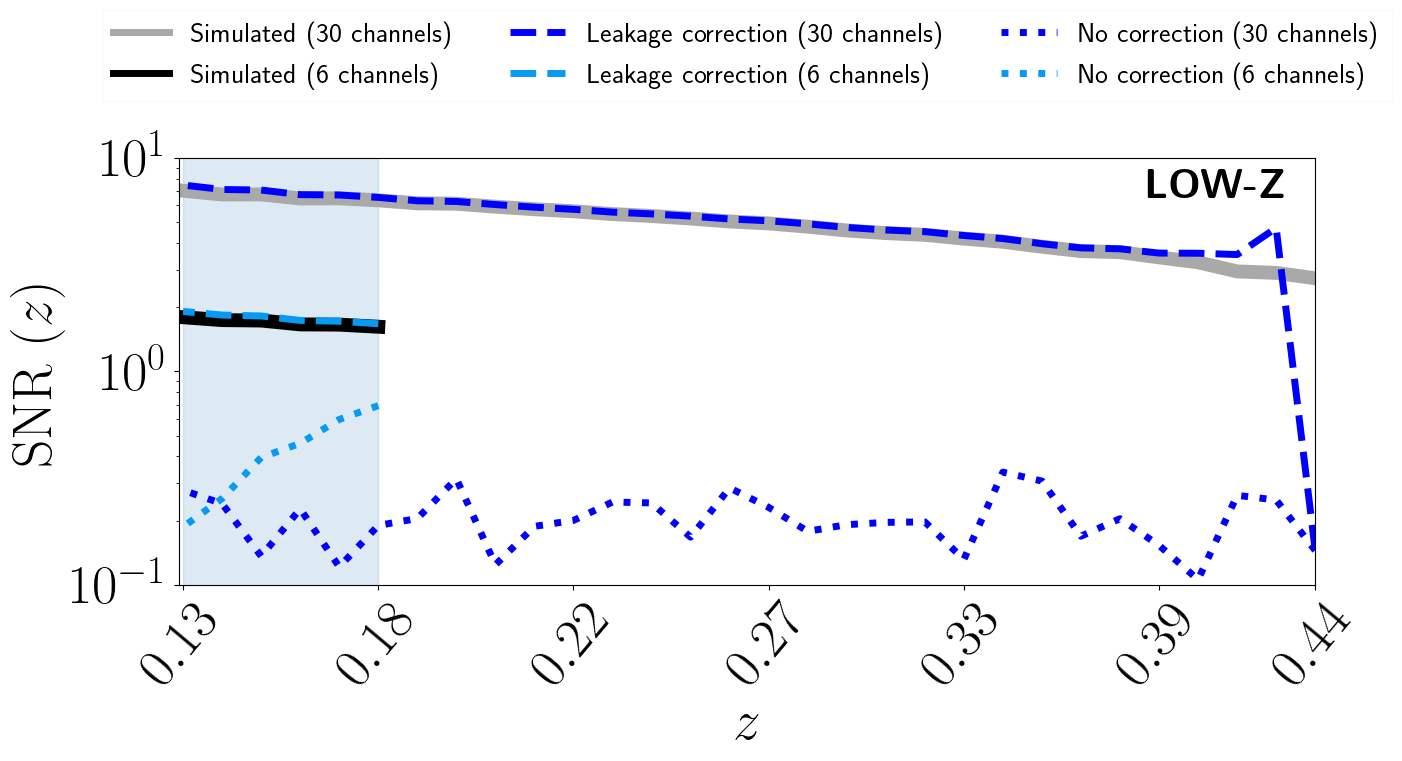

In [367]:
fig   = plt.figure()
grid  = plt.GridSpec(1,1,top=1.,right=1.9,wspace=0.3, hspace=0.0)
ax    = plt.subplot(grid[0,0])
#
cmap = plt.get_cmap(my_cmap)
###########################################################
bins_lowz = np.arange(0,30,1)
bins_lowz_cmb = dcopy(bins_lowz)
bins_lowz = np.arange(24,30,1)
bins_lowz_gal = dcopy(bins_lowz)
#
zeff_lowz_cmb = cxft.get_zeff(numin =980, numax =1260, nbands=30, n_curves=30)['zeff'][bins_lowz_cmb]
zeff_lowz_gal = cxft.get_zeff(numin =980, numax =1260, nbands=30, n_curves=30)['zeff'][bins_lowz_gal]
###########################################################
j=2;ins='ns4'
#
SN_nu_sim_dict  = dcopy(SN_lowz_cmb_sim)
SN_nu_rec_dict  = dcopy(SN_lowz_cmb_rec)
SN_nu_rec0_dict = dcopy(SN_lowz_cmb_rec0)
sn_rec  = dcopy(SN_nu_rec_dict[ins])#[bins_lowz_cmb]
sn_rec0 = dcopy(SN_nu_rec0_dict[ins])#[bins_lowz_cmb]
sn_sim  = dcopy(SN_nu_sim_dict[ins])#[bins_lowz_cmb]
ax.plot( bins_lowz_cmb+1, sn_sim , color=cmap(1),lw=10, ls='solid')
ax.plot( bins_lowz_cmb+1, sn_rec , color=cmap(j),lw=5, ls='--')
ax.plot( bins_lowz_cmb+1, sn_rec0, color=cmap(j),lw=5, ls=':')
###########################################################
j=23;ins='ns4'
#
SN_nu_sim_dict  = dcopy(SN_lowz_gal_sim)
SN_nu_rec_dict  = dcopy(SN_lowz_gal_rec)
SN_nu_rec0_dict = dcopy(SN_lowz_gal_rec0)
sn_rec  = dcopy(SN_nu_rec_dict[ins])#[bins_lowz_gal]
sn_rec0 = dcopy(SN_nu_rec0_dict[ins])#[bins_lowz_gal]
sn_sim  = dcopy(SN_nu_sim_dict[ins])#[bins_lowz_gal]
plt.plot( bins_lowz_gal+1, sn_sim , color=cmap(0),lw=10, ls='solid')
plt.plot( bins_lowz_gal+1, sn_rec , color=cmap(j),lw=5, ls='--')
plt.plot( bins_lowz_gal+1, sn_rec0, color=cmap(j),lw=5, ls=':')
###########################################################
###########################################################
ax.set_xscale('linear'); ax.set_yscale('log'); 
ax.set_xlim(1,30.1)
ax.set_ylim(1e-1,1e1)
#ax.set_yticks([1,3,10,30,60], [r'${:.1f}$'.format(z) for z in [1,3,10,30,60]])
bins_plot = np.array([0,4, 9,14, 19,24, 29])
ax.set_xticks(bins_plot+1, [r'${:.2f}$'.format(z) for z in zeff_lowz_cmb[bins_plot]], rotation =50)
ax.invert_xaxis()
ax.set_xlabel(r"$z$" , fontsize=40)
ax.set_ylabel(r"$\textrm{SNR }(z)$" , fontsize=40)    
ax.tick_params(axis='both', labelsize=40)
#
ax.fill_between(bins_lowz+1, 0, 70, color='C10', alpha=0.15)    
ax.text(x=5.3, y=6.5,s=r'$\textbf{LOW-Z}$', fontdict=font_dict)
###########################################################
custom_lines = [Line2D([], [], color=my_cmap(1) , linewidth=5, linestyle='solid'),
                Line2D([], [], color=my_cmap(0) , linewidth=5, linestyle='solid'),
                Line2D([], [], color=my_cmap(2) , linewidth=5, linestyle='--'),
                Line2D([], [], color=my_cmap(23), linewidth=5, linestyle='--'),
                Line2D([], [], color=my_cmap(2) , linewidth=5, linestyle=':'),
                Line2D([], [], color=my_cmap(23), linewidth=5, linestyle=':')
               ]


ax.legend(custom_lines, [r'Simulated (30 channels)'         , r'Simulated (6 channels)', 
                         r'Leakage correction (30 channels)', r'Leakage correction (6 channels)', 
                         r'No correction (30 channels)'     , r'No correction (6 channels)'
                        ],
          ncols=3, fontsize=20, loc='lower center',framealpha=0.1, fancybox=False,
          bbox_to_anchor=(0.5, 1.1),  shadow=False,)#edgecolor='lightblue', 
###########################################################
pathname = os.path.join( '/data/AMARINS/CMBWLxHI-CODES/images', '.'.join(('SN_comparison_overall_z_low_style3','png'))  )
if 1: plt.savefig(pathname, dpi=100, bbox_inches='tight')
pathname

'/data/AMARINS/CMBWLxHI-CODES/images/SN_comparison_overall_z_high_style3.png'

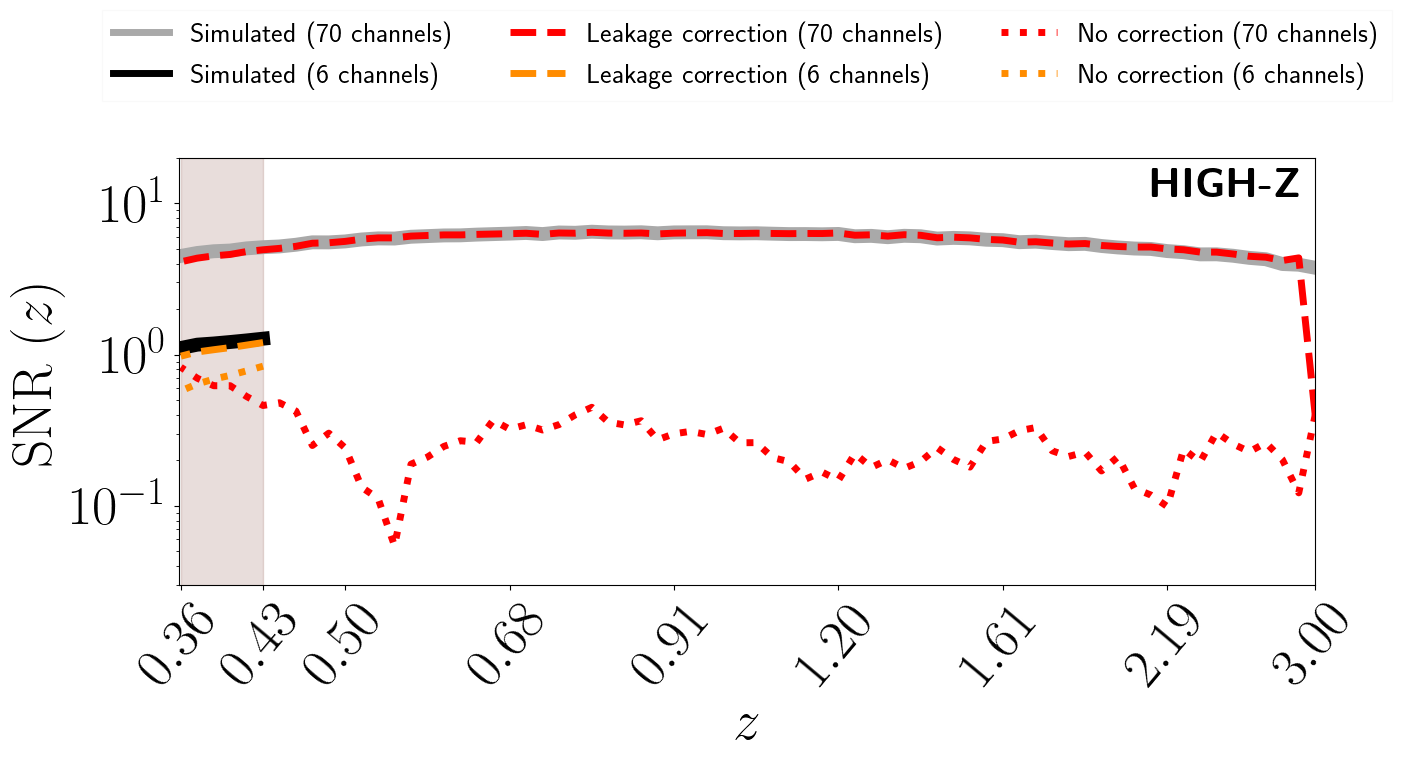

In [368]:
fig   = plt.figure()
grid  = plt.GridSpec(1,1,top=1.,right=1.9,wspace=0.3, hspace=0.0)
ax    = plt.subplot(grid[0,0])
#
cmap = plt.get_cmap(my_cmap)
###########################################################
bins_highz = np.arange(0,70,1)
bins_highz_cmb = dcopy(bins_highz)
bins_highz = np.arange(64,70,1)
bins_highz_gal = dcopy(bins_highz)
#
zeff_highz_cmb = cxft.get_zeff(numin =350, numax =1050, nbands=70, n_curves=70)['zeff'][bins_highz_cmb]
zeff_highz_gal = cxft.get_zeff(numin =350, numax =1050, nbands=70, n_curves=70)['zeff'][bins_highz_gal]
###########################################################
j=3;ins='ns4'
#
SN_nu_sim_dict  = dcopy(SN_highz_cmb_sim)
SN_nu_rec_dict  = dcopy(SN_highz_cmb_rec)
SN_nu_rec0_dict = dcopy(SN_highz_cmb_rec0)
sn_rec  = dcopy(SN_nu_rec_dict[ins])#[bins_highz_cmb]
sn_rec0 = dcopy(SN_nu_rec0_dict[ins])#[bins_highz_cmb]
sn_sim  = dcopy(SN_nu_sim_dict[ins])#[bins_highz_cmb]
ax.plot( bins_highz_cmb+1, sn_sim , color=cmap(1),lw=10, ls='solid')
ax.plot( bins_highz_cmb+1, sn_rec , color=cmap(j),lw=5, ls='--')
ax.plot( bins_highz_cmb+1, sn_rec0, color=cmap(j),lw=5, ls=':')
###########################################################
j=12;ins='ns4'
#
SN_nu_sim_dict  = dcopy(SN_highz_gal_sim)
SN_nu_rec_dict  = dcopy(SN_highz_gal_rec)
SN_nu_rec0_dict = dcopy(SN_highz_gal_rec0)
sn_rec  = dcopy(SN_nu_rec_dict[ ins])#[bins_lowz_gal]
sn_rec0 = dcopy(SN_nu_rec0_dict[ins])#[bins_lowz_gal]
sn_sim  = dcopy(SN_nu_sim_dict[ ins])#[bins_lowz_gal]
plt.plot( bins_highz_gal+1, sn_sim , color=cmap(0), lw=10, ls='solid')
plt.plot( bins_highz_gal+1, sn_rec , color=cmap(j), lw=5 , ls='--'   )
plt.plot( bins_highz_gal+1, sn_rec0, color=cmap(j), lw=5 , ls=':'    )
###########################################################
###########################################################
ax.set_xscale('linear'); ax.set_yscale('log'); 
ax.set_xlim(1,70.1)
ax.set_ylim(0.3e-1,2e1)
#ax.set_yticks([1,3,10,30,60], [r'${:.1f}$'.format(z) for z in [1,3,10,30,60]])
bins_plot = np.array([1,10,20,30,40,50,60,65,70])-1
ax.set_xticks(bins_plot+1, [r'${:.2f}$'.format(z) for z in zeff_highz_cmb[bins_plot]], rotation =50)
ax.invert_xaxis()
ax.set_xlabel(r"$z$"               , fontsize =40)
ax.set_ylabel(r"$\textrm{SNR }(z)$", fontsize =40)    
ax.tick_params(axis='both'         , labelsize=40)
###########################################################
ax.fill_between(bins_highz+1, 0, 70, color='C5', alpha=0.2)    
ax.text(x=11, y=11,s=r'$\textbf{HIGH-Z}$', fontdict=font_dict)
###########################################################
custom_lines = [Line2D([], [], color=my_cmap(1) , linewidth=5, linestyle='solid'),
                Line2D([], [], color=my_cmap(0) , linewidth=5, linestyle='solid'),
                Line2D([], [], color=my_cmap(3) , linewidth=5, linestyle='--'),
                Line2D([], [], color=my_cmap(12), linewidth=5, linestyle='--'),
                Line2D([], [], color=my_cmap(3) , linewidth=5, linestyle=':'),
                Line2D([], [], color=my_cmap(12), linewidth=5, linestyle=':')
               ]


ax.legend(custom_lines, [r'Simulated (70 channels)'         , r'Simulated (6 channels)', 
                         r'Leakage correction (70 channels)', r'Leakage correction (6 channels)', 
                         r'No correction (70 channels)'     , r'No correction (6 channels)'
                        ],
          ncols=3, fontsize=20, loc='lower center',framealpha=0.1, fancybox=False,
          bbox_to_anchor=(0.5, 1.1),  shadow=False,)#edgecolor='lightblue', 
###########################################################
pathname = os.path.join( '/data/AMARINS/CMBWLxHI-CODES/images', '.'.join(('SN_comparison_overall_z_high_style3','png'))  )
if 1: plt.savefig(pathname, dpi=100, bbox_inches='tight')
pathname